In [1]:
%%HTML
<style>
th {
  font-size: 24px
}
td {
  font-size: 16px
}
</style>

In [23]:
import torch
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
sns.set_theme(style="ticks")

# It starts with a tensor

## Core concepts of this section

1. A `Tensor` is a `View` onto a `Storage`
2. `contiguous` memory layout enables fast computations
3. `broadcasting`: expand Tensor dimensions as needed


## Fundamentals
### Contrast to python list

![in pytorch, a tensor refers to numbers in memory that are all next to each other](img/Fig23.png "src: https://www.manning.com/books/deep-learning-with-pytorch")

    
| entity | plain python | pytorch| 
|:-------|:------------:|:------:|
| numbers | **boxed**: objects with reference counting | 32 bit numbers| 
| lists | sequential (1dim) collections of pointers to python objects | **adjacent entries in memory**: optimized for computational operations | 
| interpreter | slow list and math operations | fast | 


### Instantiation

Default type at instantiation is torch.float32

In [3]:
a = torch.ones(3); print(a, a.dtype)
b = torch.zeros((3, 2)).short(); print(b)
c = torch.tensor([1.,2.,3.], dtype=torch.double); print(c)

tensor([1., 1., 1.]) torch.float32
tensor([[0, 0],
        [0, 0],
        [0, 0]], dtype=torch.int16)
tensor([1., 2., 3.], dtype=torch.float64)


In [4]:
torch.tensor??

Docstring:
tensor(data, dtype=None, device=None, requires_grad=False, pin_memory=False) -> Tensor

Constructs a tensor with :attr:`data`.

.. warning::

    :func:`torch.tensor` always copies :attr:`data`. If you have a Tensor
    ``data`` and want to avoid a copy, use :func:`torch.Tensor.requires_grad_`
    or :func:`torch.Tensor.detach`.
    If you have a NumPy ``ndarray`` and want to avoid a copy, use
    :func:`torch.as_tensor`.

.. warning::

    When data is a tensor `x`, :func:`torch.tensor` reads out 'the data' from whatever it is passed,
    and constructs a leaf variable. Therefore ``torch.tensor(x)`` is equivalent to ``x.clone().detach()``
    and ``torch.tensor(x, requires_grad=True)`` is equivalent to ``x.clone().detach().requires_grad_(True)``.
    The equivalents using ``clone()`` and ``detach()`` are recommended.

Args:
    data (array_like): Initial data for the tensor. Can be a list, tuple,
        NumPy ``ndarray``, scalar, and other types.
    dtype (:class:`torch.d

### Tensors and storages

* the `torch.Storage` is where the numbers actually are
* A `torch.Tensor` is a view onto a *torch.Storage*


In [5]:
a = torch.tensor([1,2,3,4,5,6])
b = a.reshape((3,2))
assert id(a.storage()) == id(b.storage())

* layout of the storage is always *1D*
* hence, changing the value in the storage changes the values of all views (i.e. torch.Tensor) that refer to the same storage 

![Views referring to same storage](img/Fig24.png)

### Size, storage offset, and strides

![Meaning of size, offset and stride](img/Fig25.png)

* A Tensor is a view on a storage that is defined by its
  * **size:** `t.size()` / `t.shape`
  * **storage offset:** `t.stoage_offset()`
  * **stride:** `t.stride()`
* the **stride** informs how many elements in the storage one needs to move to get to the next value in that dimension
* to get `t[i,j]`, get `storage_offset + i * stride[0] + j * stride[1]` of storage
* this makes some tensor operations very cheap, because a new tensor has the same storage but different values for size, offset and stride

In [6]:
a = torch.tensor([[1,2,3], [4,5,6]])
print(f"a.size: {a.size()}")
print(f"a.storage_offset: {a.storage_offset()}")
print(f"a.stride: {a.stride()}")

a.size: torch.Size([2, 3])
a.storage_offset: 0
a.stride: (3, 1)


In [7]:
b = a[1]
print(f"b.size: {b.size()}")
print(f"b.storage_offset: {b.storage_offset()}")
print(f"b.stride: {b.stride()}")

b.size: torch.Size([3])
b.storage_offset: 3
b.stride: (1,)


#### Transposing a tensor

* the transpose just swaps entries in size and stride

![Transpose explained](img/Fig26.png)


#### Contiguous

* A tensor whose values are laid out in the storage starting from the right most dimension onward is **contiguous**
  * e.g. 2D tensor:
    * `t.size() # torch.Size([#rows, #columns])`
    * moving along rows (i.e. fix row, go from one column to the next) is equivalent to going through storage one by one
* this data locality improves performance

In [8]:
a = torch.tensor([[1,2,3], [4,5,6]])
assert a.is_contiguous()

In [9]:
b = a.t()
assert not b.is_contiguous()

In [10]:
c = b.contiguous()
assert c.is_contiguous()

### Numeric types

* `torch.floatXX`: 32: float, 64: double, 16: half
* `torch.intXX`: 8, 16, 32, 64
* `torch.uint8`: torch.ByteTensor
* `torch.Tensor`: equivalent to torch.FloatTensor


### Indexing

* similar to [numpy indexing](https://numpy.org/devdocs/user/basics.indexing.html), e.g. `points[1:, 0]`: all but first rows, first column

### Exercises

1. Create a tensor a from list(range(9)) . Predict then check what the size, offset, and strides are.
2. Create a tensor b = a.view(3, 3) . What is the value of b[1,1] ?
3. Create a tensor c = b[1:,1:] . Predict then check what the size, offset, and strides are.

## Tensor features

In [11]:
t = torch.tensor([1,2,3,4,5,6])

### Numpy interoperability

In [12]:
t_np = t.numpy()
t = torch.from_numpy(t_np)

### Serialization

* use `torch.save(t, "path_to_file.t")` and `torch.load("path_to_file.t")`
* alternatively, can use in combination with `hdf5` file format (library: h5py)

### GPU

* pytorch makes it very easy to use one or several GPUs, using the `torch.device`

In [13]:
torch.device("cpu") # use cpu by default
torch.device("cuda") # GPU
torch.device("cuda:0") # index multiple GPUs #0 -> default: 0
torch.device("cuda:1") # use GPU #1

device(type='cuda', index=1)

* delegate a tensor to a device using

In [14]:
print(t.to(torch.device("cpu")))
print(t.cpu())

if torch.cuda.is_available():
    print(t.cuda())
    print(t.cuda(0))

tensor([1, 2, 3, 4, 5, 6])
tensor([1, 2, 3, 4, 5, 6])
tensor([1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([1, 2, 3, 4, 5, 6], device='cuda:0')


### Tensor API

For pytorch, there exists a ton of ops... whatever you would like to do, it's probably already implemented in a performant manner.

**Pytorch convention:** a mathemtical operation often has an in-place equivalent referenced by using the suffix `_`. E.g. `t.cos()` and `t.cos_()`

Some examples:

In [15]:
t = torch.tensor(range(10), dtype=torch.float) 

In [16]:
t.cos()

tensor([ 1.0000,  0.5403, -0.4161, -0.9900, -0.6536,  0.2837,  0.9602,  0.7539,
        -0.1455, -0.9111])

In [17]:
t.log()

tensor([  -inf, 0.0000, 0.6931, 1.0986, 1.3863, 1.6094, 1.7918, 1.9459, 2.0794,
        2.1972])

In [18]:
t.log_(); t # operates in-place/ mutates tensor

tensor([  -inf, 0.0000, 0.6931, 1.0986, 1.3863, 1.6094, 1.7918, 1.9459, 2.0794,
        2.1972])

### Exercise

1. Caclulate the mean squared error between predictions and target values: $\rm mse = \frac{1}{N}\sum_i^N (p_i - t_i)^2$


In [19]:
def mse(p, t):
    # TODO: implement
    return torch.zeros(len(p)) 

x = torch.tensor([0.8878, 0.3297, 0.5110, 0.5384, 0.2123, 0.3426, 0.7011, 0.8208, 0.8864, 0.6434, 0.1740, 0.0737, 0.8329, 0.0571, 0.6244, 0.9390, 0.5501, 0.6998, 0.7668, 0.5981, 0.1187, 0.6488, 0.3909, 0.8849, 0.3510, 0.7472, 0.4878, 0.2781, 0.5326, 0.1480, 0.4136, 0.4267, 0.6989, 0.3887, 0.5068, 0.5511, 0.5643, 0.0901, 0.1359, 0.5701, 0.4774, 0.9935, 0.1502, 0.7608, 0.4538, 0.4217, 0.1825, 0.9382, 0.8646, 0.1383, 0.0363, 0.2364, 0.1937, 0.2695, 0.4807, 0.7768, 0.2784, 0.3547, 0.0922, 0.5994, 0.0868, 0.0460, 0.0812,
        0.0319, 0.2429, 0.3504, 0.6014, 0.9268, 0.2222, 0.5592, 0.2112, 0.3517, 0.1994, 0.3877, 0.8518, 0.3747, 0.9385, 0.5225, 0.9855, 0.7657, 0.5585, 0.0929, 0.5815, 0.0804, 0.9209, 0.8802, 0.6289, 0.9143, 0.0038, 0.7857, 0.9591, 0.8305, 0.1844, 0.0162, 0.1324, 0.0526, 0.2213, 0.6377, 0.6446, 0.6945])
y = torch.tensor([0.2142, 0.7458, 0.7008, 0.2043, 0.1460, 0.2145, 0.7116, 0.6624, 0.8765, 0.2938, 0.4653, 0.1229, 0.8056, 0.2956, 0.4171, 0.0459, 0.3799, 0.5624, 0.4551, 0.1322, 0.7540, 0.0425, 0.3713, 0.4406, 0.8243, 0.5511, 0.1352, 0.7495, 0.0901, 0.2131, 0.7758, 0.9060, 0.7875, 0.5118, 0.5368, 0.3445, 0.8501, 0.2982, 0.2606, 0.4571, 0.8108, 0.7400, 0.2336, 0.6150, 0.9143,
        0.4178, 0.2335, 0.5490, 0.4379, 0.3335, 0.8449, 0.6327, 0.1062, 0.4313, 0.7856, 0.6156, 0.3859, 0.5551, 0.4448, 0.3231, 0.3505, 0.3295, 0.8727, 0.9072, 0.9495, 0.6936, 0.5648, 0.0132, 0.2811, 0.5219, 0.4193, 0.8747, 0.7140, 0.6307, 0.0449, 0.4598, 0.0337, 0.3839, 0.7451, 0.2710, 0.3802, 0.8890, 0.8482, 0.6723, 0.7480, 0.1293, 0.6862, 0.8104, 0.3573, 0.7695, 0.1230, 0.3649, 0.8067, 0.2198, 0.3240, 0.1938, 0.8909, 0.1115, 0.4997, 0.4708])

torch.testing.assert_allclose(mse(x, y), 0.16112)
torch.testing.assert_allclose(mse(torch.ones(3), torch.ones(3)), 0)

AssertionError: With rtol=0.0001 and atol=1e-05, found 100 element(s) (out of 100) whose difference(s) exceeded the margin of error (including 0 nan comparisons). The greatest difference was 0.1611199975013733 (0.0 vs. 0.1611199975013733), which occurred at index 99.

## Boardcasting

## Auto grad
### Key Concepts

1. `requires_grad` 
2. `t.backward()` and `param.grad`
3. `param.detach` and `torch.no_grad()` 
4. zeroing the gradient
    

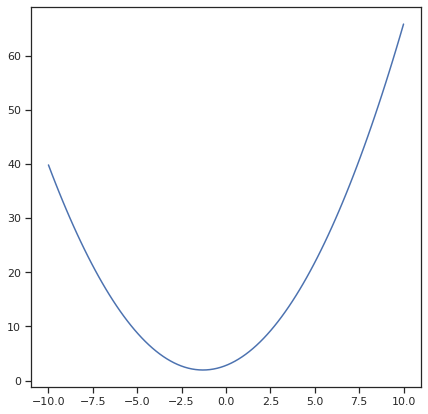

In [28]:
def sop(x, a, b, c):
    return a*x**2 + b*x + c

def show_sop(x, y):
    fig, ax = plt.subplots(1, figsize=(7,7))
    ax.plot(x, y)

a, b, c = 0.5, 1.3, 2.8

x = np.linspace(-10, 10, 100)

show_sop(x, sop(x, a, b, c))

In [37]:
x = torch.tensor([-1.3], requires_grad=True)
sop(x, a, b, c).backward()

assert x.grad == 2*a*x + b

print(x.grad)

tensor([0.])


### Exercise: Least square fit for a linear function

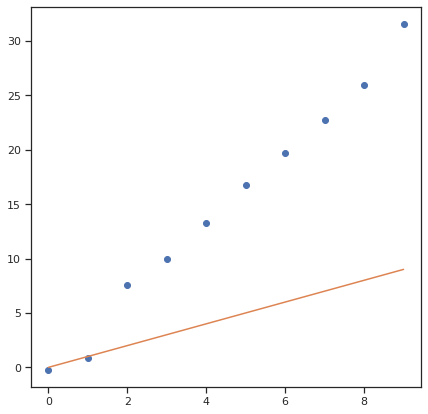

In [20]:
def model(x, params):
    return params[0]*x + params[1]

def noise(signal):
    n = torch.zeros(signal.shape)
    torch.nn.init.normal_(n)
    return n

def mse(p, t):
    return (p - t).pow(2).mean()

def show_fit(x, p, t):
    fig, ax = plt.subplots(1, figsize=(7,7))
    ax.plot(x.numpy(), t.numpy(), marker="o", linewidth=0)
    ax.plot(x.numpy(), p.numpy())

initial_parmas = torch.tensor([1., 0.])
target_params = torch.tensor([3.4, -0.8])

x = torch.tensor(range(10))
data = model(x, target_params) + noise(x)

assert mse(model(x, initial_parmas), data) > 100

show_fit(x, model(x, initial_parmas), data)

Loss at epoch [0]: [156.83314514160156]
Loss at epoch [1]: [28.10074806213379]
Loss at epoch [2]: [5.857351779937744]
Loss at epoch [3]: [2.0113203525543213]
Loss at epoch [4]: [1.3437001705169678]
Loss at epoch [5]: [1.2252275943756104]
Loss at epoch [6]: [1.2016626596450806]
Loss at epoch [7]: [1.1945286989212036]
Loss at epoch [8]: [1.19026780128479]
Loss at epoch [9]: [1.1865365505218506]


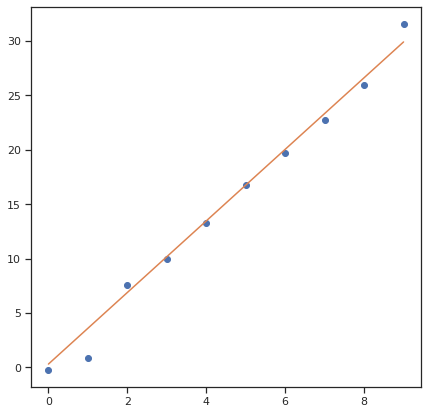

In [21]:
lr = 0.01
n_epochs = 10
initial_parmas = torch.tensor([1., 0.], requires_grad=True)

for epoch in range(n_epochs):
    # calculate loss
    loss = mse(model(x, initial_parmas), data)
    print(f"Loss at epoch [{epoch}]: [{loss.item()}]")
    
    # propagate error
    loss.backward()
    
    # update weights
    with torch.no_grad():
        initial_parmas -= lr * initial_parmas.grad.data
        initial_parmas.grad.data.zero_()
    
with torch.no_grad():
    show_fit(x, model(x, initial_parmas), data)